# ml03_philip.ipynb
Machine Learning with the Titanic Dataset
Philip Fowler
18 March 2025
This notebook is a simple example of machine learning using the Titanic dataset.
The goal is to predict whether a passenger survived the Titanic disaster based on their attributes.
The dataset is available from the Seaborn library.

In [240]:
# install libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from pandas.plotting import scatter_matrix

sns.set_style('whitegrid')


## Section 1. Load and Explore the Data

### 1.1 Load the dataset and display the first 10 rows

In [241]:
# Load Titanic dataset
titanic = sns.load_dataset('titanic')

titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


what is the difference in pclass vs class?  Can we drop class?
what is the difference between sex and who?  Can we drop who?
Why a separate column for adult male?
Do we ned to keep emarked town?
Is alive the same as survived?
How is alone useful?

survived is the target variable 1=survived, 0=died
pclass is the ticket class 1=1st, 2=2nd, 3=3rd
name, sex, age seem straightforward!
sibsp is the number of siblings/spouses aboard
parch is the number of parents/children aboard
ticket is the ticket number
fare is the passenger fare
cabin is the cabin number
embarked is the port of embarkation C=Cherbourg, Q=Queenstown, S=Southampton

In [242]:
titanic.head(10)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False
8,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,NaN,Southampton,yes,False
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,NaN,Cherbourg,yes,False


### 1.2 Check for missing values and display summary statistics


In [243]:
titanic.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

Age is likely important and has a lot of missing values.  I will need a strategy to address this.  Not sure about deck.  Can it be dropped?

## Section 2. Visualize Feature Distributions


In [244]:
titanic.describe().T

,count,mean,std,min,25%,50%,75%,max
survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
sibsp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [245]:
titanic.corr(numeric_only=True)

,survived,pclass,age,sibsp,parch,fare,adult_male,alone
survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,-0.557080,-0.203367
pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,0.094035,0.135207
age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.280328,0.198270
sibsp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,-0.253586,-0.584471
parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,-0.349943,-0.583398
fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,-0.182024,-0.271832
adult_male,-0.557080,0.094035,0.280328,-0.253586,-0.349943,-0.182024,1.000000,0.404744
alone,-0.203367,0.135207,0.198270,-0.584471,-0.583398,-0.271832,0.404744,1.000000


The above correlations were done to determine a better way to fill in the missing values for age.  It seems to me that 1st class passengers are likely older than third class passengers.  Thus, perhaps we should fill the missing values for age using the median based on passenger class.

1) How many data instances are there? 891
2) How many features are there? 15
3) What are the names? 'survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']
4) Are there any missing values? Yes, mostly in age and deck.  2 from embark town and embarked
5) Are there any non-numeric features? Yes, sex, embarked, class, who, adult_male, deck, embark_town, alive, alone

6) Are the data instances sorted on any of the attributes? No
7) What are the units of age? Years
8) What are the minimum, median and max age? min: 0.42, median: 28.0, max: 80.0
9) What two different features have the highest correlation?

10) Are there any categorical features that might be useful for prediction? I know a bit about this dataset, so I know that sex and passenger class are important features for predicting survival.

### 2.1 Create histograms, boxplots, and scatterplots


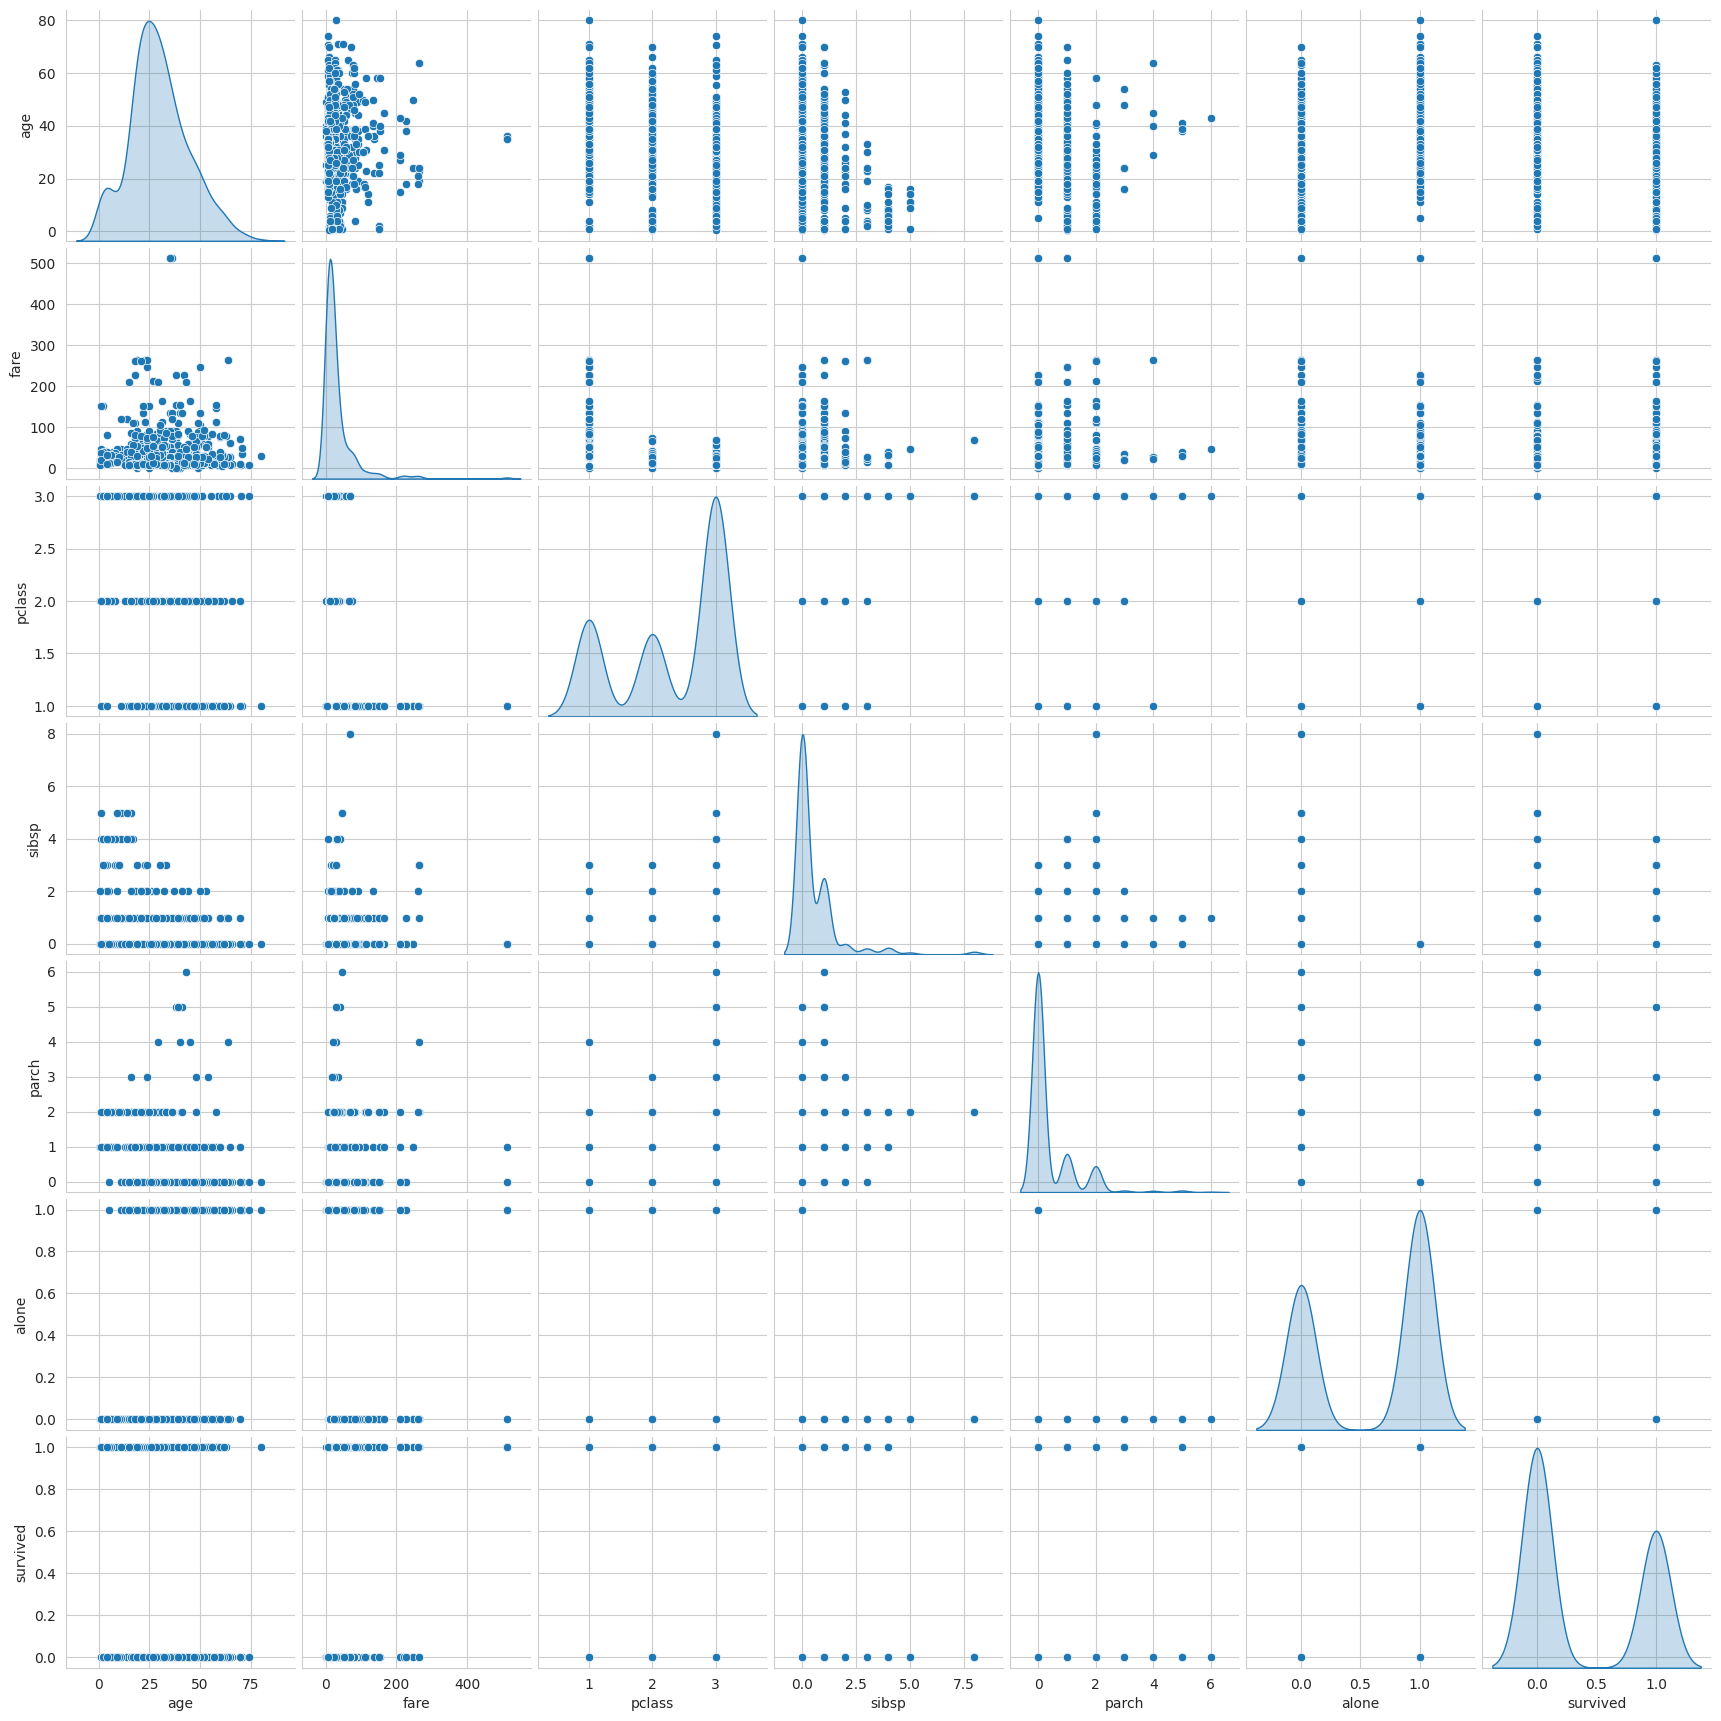

In [246]:
attributes = ['age', 'fare', 'pclass', 'sex', 'sibsp', 'parch', 'alone', 'survived']
sns.pairplot(titanic[attributes], diag_kind='kde')
plt.show()

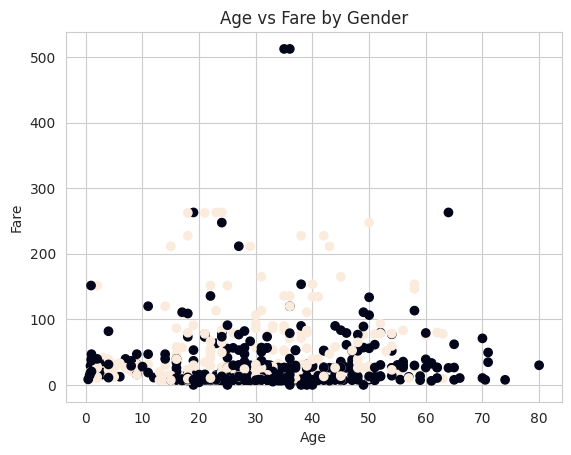

In [247]:
plt.scatter(titanic['age'], titanic['fare'], c=titanic['sex'].apply(lambda x: 0 if x == 'male' else 1))
plt.xlabel('Age')
plt.ylabel('Fare')
plt.title('Age vs Fare by Gender')
plt.show()

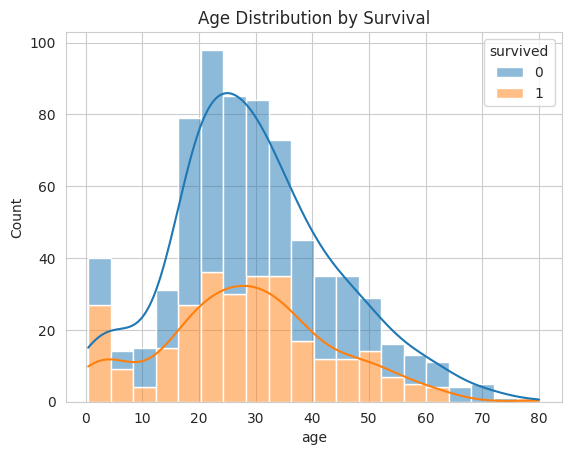

In [248]:
sns.histplot(data=titanic, x='age', hue='survived', kde=True, multiple='stack')
plt.title('Age Distribution by Survival')
plt.show()

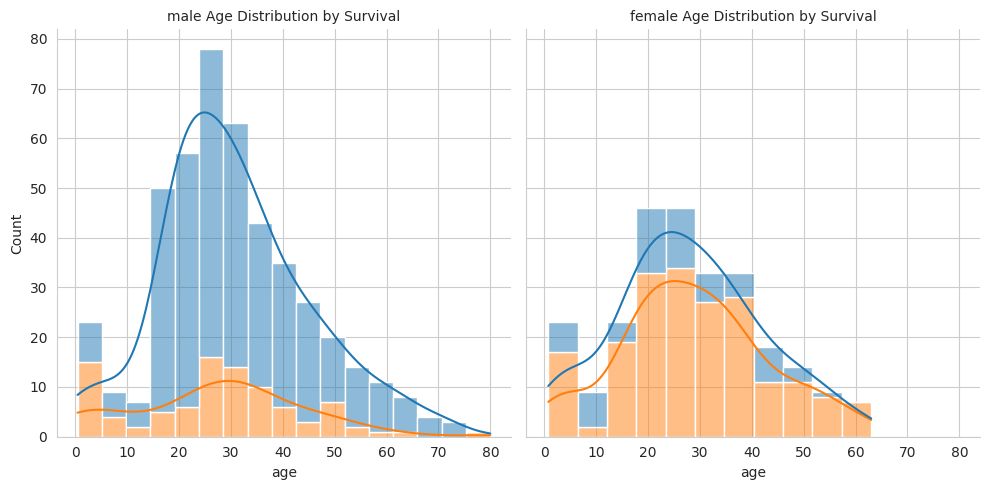

In [249]:
g = sns.FacetGrid(titanic, col="sex", height=5, aspect=1)
g.map(sns.histplot, "age", hue="survived", data=titanic, kde=True, multiple="stack")
g.set_titles("{col_name} Age Distribution by Survival")
plt.show()

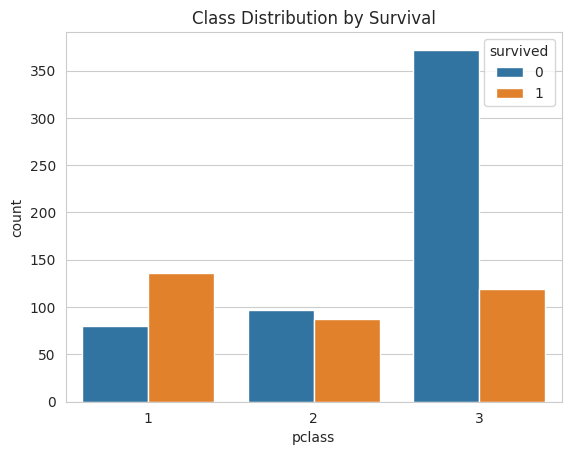

In [250]:
sns.countplot(x='pclass', hue='survived', data=titanic)
plt.title('Class Distribution by Survival')
plt.show()

Reflection 2.1:


1. What patterns or anomalies do you notice? third class passengers are more likely to not survive
2. Do any features stand out as potential predictors? class and sex
3. Are there any visible class imbalances? Yes, in third class passengers

### 2.2 Feature Engineering

In [251]:
titanic['age'] = titanic['age'].fillna(titanic['age'].median())

# why are we using embarked town when we have embarked column?
titanic['embark_town'] = titanic['embark_town'].fillna(titanic['embark_town'].mode()[0])


In [252]:
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})
titanic['embarked'] = titanic['embarked'].map({'C': 0, 'Q': 1, 'S': 2})

titanic['alone'] = titanic['alone'].astype(int)


Reflection 2.3

Why might family size be a useful feature for predicting survival? Perhaps being together with family increased the likelihood of survival.  This would certainly be true for small children.
Why convert categorical data to numeric? It is easier to work with numeric data in machine learning models.



## Section 3. Feature Selection and Justification
### 3.1 Choose input features for predicting the target

In [253]:
# from lab 2
X = titanic[['age', 'fare', 'pclass', 'sex', 'family_size']]
y = titanic['survived']

In [254]:
# Case 1: alone only 
#X = titanic[['alone']]
#y = titanic['survived']

# Case 2: age only (or your choice)
# X = titanic[['age']]
# y = titanic['survived']

# Case 3: age + family_size (or your choice)
# X = titanic[['age', 'family_size']]
# y = titanic['survived']

Reflection 3:

Why are these features selected? These are the features that appear to be the best for predicting survival.
Are there any features that are likely to be highly predictive of survival? 

## Section 4. Train a Model
### 4.1 Split the data


In [255]:
dont_panic = 42
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=dont_panic)

for train_indices, test_indices in splitter.split(X, y):
    X_train = X.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_train = y.iloc[train_indices]
    y_test = y.iloc[test_indices]

print('Train size: ', len(X_train), 'Test size: ', len(X_test))

Train size:  712 Test size:  179


Reflection 4:

Why might stratification improve model performance?  Stratification ensures that the train and test sets have the same class percentages.  
How close are the training and test distributions to the original dataset? The training and test sets are very close to the original dataset.  The class percentages are almost identical.
Which split method produced better class balance? Stratified split

### 4.2 Train the models


In [257]:
# Create the logistic model
logistic_model = LogisticRegression(max_iter=1000, random_state=dont_panic)

# Train the model
logistic_model.fit(X_train, y_train)

# Make predictions
y_pred_logistic = logistic_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_logistic)
conf_matrix = confusion_matrix(y_test, y_pred_logistic)
class_report = classification_report(y_test, y_pred_logistic)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.8100558659217877
Confusion Matrix:
[[95 15]
 [19 50]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       110
           1       0.77      0.72      0.75        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



In [258]:
# Create the decision tree model
tree_model = DecisionTreeClassifier()

# Train the model
tree_model.fit(X_train, y_train)

# Make predictions
y_pred_tree = tree_model.predict(X_train)

# Evaluate the model
accuracy = accuracy_score(y_train, y_pred_tree)
conf_matrix = confusion_matrix(y_train, y_pred_tree)
class_report = classification_report(y_train, y_pred_tree)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.9817415730337079
Confusion Matrix:
[[436   3]
 [ 10 263]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       439
           1       0.99      0.96      0.98       273

    accuracy                           0.98       712
   macro avg       0.98      0.98      0.98       712
weighted avg       0.98      0.98      0.98       712



In [259]:
# Create the SVM model
svm_model = SVC(kernel='rbf', random_state=dont_panic)

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_train)

# Evaluate the model
accuracy = accuracy_score(y_train, y_pred_svm)
conf_matrix = confusion_matrix(y_train, y_pred_svm)
class_report = classification_report(y_train, y_pred_svm)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.6980337078651685
Confusion Matrix:
[[400  39]
 [176  97]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.91      0.79       439
           1       0.71      0.36      0.47       273

    accuracy                           0.70       712
   macro avg       0.70      0.63      0.63       712
weighted avg       0.70      0.70      0.67       712



In [260]:
# Create the neural network model
nn_model = MLPClassifier(hidden_layer_sizes=(50, 25, 10), solver='lbfgs', random_state=dont_panic)

# Train the model
nn_model.fit(X_train, y_train)

# Make predictions
y_pred_nn = nn_model.predict(X_train)

# Evaluate the model
accuracy = accuracy_score(y_train, y_pred_nn)
conf_matrix = confusion_matrix(y_train, y_pred_nn)
class_report = classification_report(y_train, y_pred_nn)    

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)


Accuracy: 0.8146067415730337
Confusion Matrix:
[[378  61]
 [ 71 202]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       439
           1       0.77      0.74      0.75       273

    accuracy                           0.81       712
   macro avg       0.80      0.80      0.80       712
weighted avg       0.81      0.81      0.81       712



/home/philip/nwmissouri/applied-ml-philip/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### 4.3 Report R^2, MAE, RMSE
Evaluate the model using R^2, MAE, and RMSE.

In [261]:
# Logistic Regression R2 score
r2_logistic = r2_score(y_test, y_pred_logistic)
print(f'R² score: {r2_logistic}')

R² score: 0.19815546772068515


In [262]:
# Decision Tree R2 score
r2_tree = r2_score(y_train, y_pred_tree)
print(f'R² score: {r2_tree}')

R² score: 0.9227681961167155


In [263]:
# SVM R2 score
r2_svm = r2_score(y_train, y_pred_svm)
print(f'R² score: {r2_svm}')

R² score: -0.2772952180697057


In [264]:
# Neural Network R2 score
r2_nn = r2_score(y_train, y_pred_nn)    
print(f'R² score: {r2_nn}')

R² score: 0.21580014518511093


In [265]:
# Logistic Regression Mean Squared Error
mae_logistic = mean_absolute_error(y_test, y_pred_logistic)
print(f'Mean Absolute Error (MAE): {mae_logistic}')

Mean Absolute Error (MAE): 0.18994413407821228


In [266]:
# Decision Tree Mean Squared Error
mae_tree = mean_absolute_error(y_train, y_pred_tree)
print(f'Mean Absolute Error (MAE): {mae_tree}')

Mean Absolute Error (MAE): 0.018258426966292134


In [267]:
# SVM Mean Squared Error
mae_svm = mean_absolute_error(y_train, y_pred_svm)
print(f'Mean Absolute Error (MAE): {mae_svm}')

Mean Absolute Error (MAE): 0.30196629213483145


In [268]:
# Neural Network Mean Squared Error
mae_nn = mean_absolute_error(y_train, y_pred_nn)
print(f'Mean Absolute Error (MAE): {mae_nn}')

Mean Absolute Error (MAE): 0.1853932584269663


In [269]:
# Logistic Regression Root Mean Squared Error
rmse_logistic = np.sqrt(mean_squared_error(y_test, y_pred_logistic))
print(f'Root Mean Squared Error (RMSE): {rmse_logistic}')

Root Mean Squared Error (RMSE): 0.43582580703557733


In [270]:
# Decision Tree Root Mean Squared Error
rmse_tree = np.sqrt(mean_squared_error(y_train, y_pred_tree))
print(f'Root Mean Squared Error (RMSE): {rmse_tree}')

Root Mean Squared Error (RMSE): 0.1351237468629853


In [271]:
# SVM Root Mean Squared Error
rmse_svm = np.sqrt(mean_squared_error(y_train, y_pred_svm))
print(f'Root Mean Squared Error (RMSE): {rmse_svm}')

Root Mean Squared Error (RMSE): 0.54951459683509


In [272]:
# Neural Network Root Mean Squared Error
rmse_nn = np.sqrt(mean_squared_error(y_train, y_pred_nn))
print(f'Root Mean Squared Error (RMSE): {rmse_nn}')

Root Mean Squared Error (RMSE): 0.43057317430021846
